# Team 5 members: Ang Boon Yew (A0096966E), Tea Lee Seng (A0198538J), Yang Xiaoyan (A0056720L)

In [1]:
# -*- coding: utf-8 -*-

# Import libraries
# .................

import os
import librosa   #for audio processing
import warnings
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics

from scipy.io import wavfile #for audio processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from datetime import datetime 

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# ...........................................................................

                                        # basic setup

audioPth        = 'speechsub'
resmpRate       = 8000
inputLength     = 8000
modelname       = 'speechRV1'

                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

Inspecting data  ... 


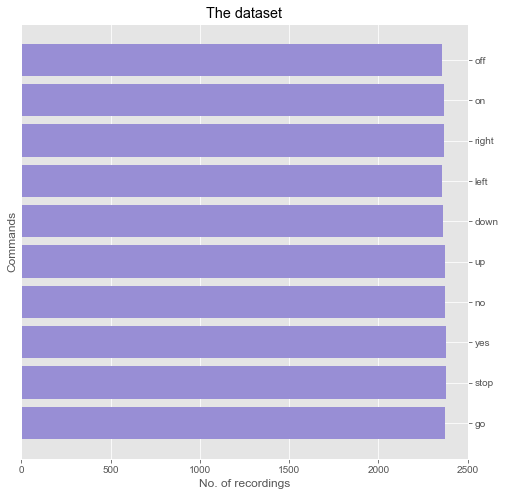

In [3]:
# ............................................................................
print("Inspecting data  ... ")
# Inspect the data set
labels      = ["go",
               "stop",
               "yes", 
               "no", 
               "up", 
               "down", 
               "left", 
               "right", 
               "on", 
               "off"]

                                            # Check the number of records available in
                                            # each category
numOfRecords= []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
                                            # Get all the wave files in each directory
    
    numOfRecords.append(len(records))       # Get the number of wave files in each directory

plt.figure(figsize=(8,8))
plt.barh(np.arange(len(labels)), 
         numOfRecords,
         color="C2")
plt.xlabel('No. of recordings')
plt.ylabel('Commands')
plt.yticks(np.arange(len(labels)), labels)
plt.title('The dataset')
plt.show()

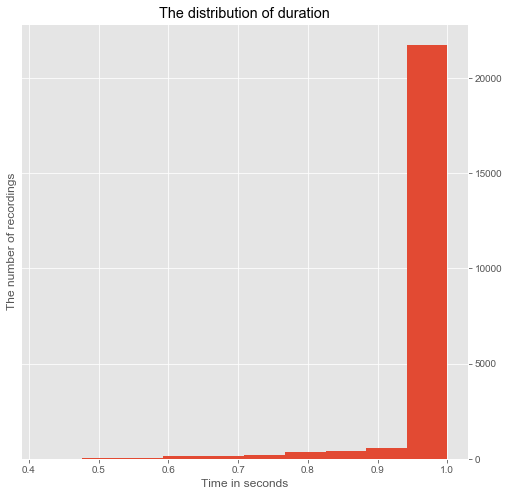

In [4]:
                                            # Check distribution of durations in 
                                            # the dataset
durations   = []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
                                            # Get all the wave files in each directory

    for rcd in records:
        (smpR,smp)  = wavfile.read(os.path.join(pth,rcd))
        
        durations.append(float(len(smp)/smpR))      
                                            # Get the duration for each wave file

plt.figure(figsize=(8,8))
plt.title('The distribution of duration')
plt.ylabel('The number of recordings')
plt.xlabel('Time in seconds')
durationHist    = plt.hist(durations)

In [5]:
features = []
sr=16000

## mfccsscaled is the mean of mfcc, use this features for the training with MLP model. The accuracy is always around 0.5 maybe due to the mfcc features have been scaled.

In [6]:
# def extract_features(smp, sr):
   
#     try:
#         audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
#         mfccs = librosa.feature.mfcc(y=smp, sr=sr, n_mfcc=60)
#         mfccsscaled = np.mean(mfccs.T,axis=0)

#     except Exception as e:
#         print("Error encountered while parsing file: ", file_name)
#         return None 
     
#     return mfccsscaled

In [7]:
# for lbl in labels:
#     pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
#     records = [f for f in os.listdir(pth) if f.endswith('.wav')]
#                                             # Get all the wave files in each directory

#     for rcd in records:
#         file_name = os.path.join(pth,rcd)
#         class_label = lbl
#         data = extract_features(file_name)
#         features.append([data, class_label])

In [8]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.optimizers import Adam
# #from tensorflow.keras.utils import np_utils
# from sklearn import metrics 

# num_labels = yy.shape[1]
# filter_size = 2

# # Construct model 
# model = Sequential()
# model.add(Dense(256, input_shape=(60,)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(num_labels))
# model.add(Activation('softmax'))

## Use mfcc features to train a CNN model, the accuracy is above 0.9 which is much better than mfcc scaled features.

In [9]:
def extract_features(smp):
    try:
        mfccs = librosa.feature.mfcc(y=smp, sr=sr, n_mfcc=60)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [10]:
for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
        # Get all the wave files in each directory
    for rcd in records:
        file_name = os.path.join(pth,rcd)
        class_label = lbl
        (smp,smpR)  = librosa.load(file_name,sr = sr)
        # only extract the mfcc features with length of 1 second audios
        if (len(smp)==sr):
            data = extract_features(smp)
            features.append([data, class_label])

In [11]:
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
import pickle
f=open('./mfccFeatures.pk','wb')
pickle.dump(featuresdf, f)
f.close()

In [12]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf['feature'].tolist())
y = np.array(featuresdf['class_label'].tolist())

In [13]:
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
num_labels = yy.shape[1]
print(le.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'up' 'yes']


In [15]:
num_rows = 60 # equal to n_mfcc when do the mfcc feature extraction
num_columns = 32 # 16000 / 512 = 31.25 roundup to 32, melspectrogram function, the default hop_lengths is 512
num_channels = 1

# split the dataset into training, validation and test sets
x_train_r, x_TV_r, y_train_r, y_TV_r = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_valid_r, x_test_r, y_valid_r, y_test_r = train_test_split(x_TV_r,y_TV_r, test_size=0.3, random_state = 42)

In [16]:
x_train_r.shape

(17049, 60, 32)

In [17]:
x_train_r = x_train_r.reshape(x_train_r.shape[0], num_rows, num_columns, num_channels)
x_valid_r = x_valid_r.reshape(x_valid_r.shape[0], num_rows, num_columns, num_channels)
x_test_r = x_test_r.reshape(x_test_r.shape[0], num_rows, num_columns, num_channels)

In [18]:
x_train_r.shape

(17049, 60, 32, 1)

In [19]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 59, 31, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 15, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 7, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 7, 32)         0         
_________________________________________________________________
con

In [21]:
num_batch_size = 128
num_epochs = 100
checkpointer = ModelCheckpoint(filepath='weights.best.speechDL.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
history = model.fit(x_train_r, y_train_r, batch_size=num_batch_size, epochs=num_epochs, 
                    validation_data=(x_valid_r, y_valid_r), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Instructions for updating:
Use tf.cast instead.
Train on 17049 samples, validate on 2984 samples
Epoch 1/100
17024/17049 [============================>.] - ETA: 0s - loss: 3.0957 - acc: 0.1178
Epoch 00001: val_loss improved from inf to 2.24323, saving model to weights.best.speechDL.hdf5
17049/17049 [==============================] - 12s - loss: 3.0946 - acc: 0.1177 - val_loss: 2.2432 - val_acc: 0.2185
Epoch 2/100
17024/17049 [============================>.] - ETA: 0s - loss: 2.1694 - acc: 0.1990
Epoch 00002: val_loss improved from 2.24323 to 1.90265, saving model to weights.best.speechDL.hdf5
17049/17049 [==============================] - 11s - loss: 2.1691 - acc: 0.1990 - val_loss: 1.9026 - val_acc: 0.4032
Epoch 3/100
17024/17049 [============================>.] - ETA: 0s - loss: 1.8707 - acc: 0.3239
Epoch 00003: val_loss improved from 1.90265 to 1.42138, saving model to weights.best.speechDL.hdf5
17049/17049 [==============================] - 12s - loss: 1.8700 - acc: 0.3241 - val_lo

17049/17049 [==============================] - 13s - loss: 0.6058 - acc: 0.7915 - val_loss: 0.3420 - val_acc: 0.8948
Epoch 27/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.6020 - acc: 0.7928- - ETA: 2s - lo
Epoch 00027: val_loss improved from 0.34197 to 0.33074, saving model to weights.best.speechDL.hdf5
17049/17049 [==============================] - 13s - loss: 0.6020 - acc: 0.7928 - val_loss: 0.3307 - val_acc: 0.8991
Epoch 28/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.5960 - acc: 0.7946
Epoch 00028: val_loss did not improve from 0.33074
17049/17049 [==============================] - 12s - loss: 0.5961 - acc: 0.7945 - val_loss: 0.3508 - val_acc: 0.8981
Epoch 29/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.5823 - acc: 0.8008- 
Epoch 00029: val_loss did not improve from 0.33074
17049/17049 [==============================] - 12s - loss: 0.5821 - acc: 0.8008 - val_loss: 0.3402 - val_acc: 0.8975
Epoch 30/100
17024/170

17024/17049 [============================>.] - ETA: 0s - loss: 0.4183 - acc: 0.8561
Epoch 00084: val_loss did not improve from 0.23619
17049/17049 [==============================] - 13s - loss: 0.4182 - acc: 0.8560 - val_loss: 0.2456 - val_acc: 0.9196
Epoch 85/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4102 - acc: 0.8622
Epoch 00085: val_loss did not improve from 0.23619
17049/17049 [==============================] - 13s - loss: 0.4101 - acc: 0.8622 - val_loss: 0.2382 - val_acc: 0.9233
Epoch 86/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4118 - acc: 0.8584
Epoch 00086: val_loss did not improve from 0.23619
17049/17049 [==============================] - 13s - loss: 0.4122 - acc: 0.8583 - val_loss: 0.2449 - val_acc: 0.9199
Epoch 87/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.4095 - acc: 0.8604
Epoch 00087: val_loss improved from 0.23619 to 0.22839, saving model to weights.best.speechDL.hdf5
17049/17049 [=========

In [22]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train_r, y_train_r, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test_r, y_test_r, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9531937357029738
Testing Accuracy:  0.9272869429707621


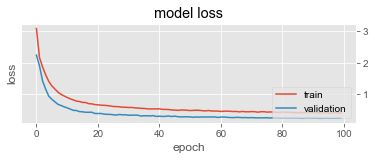

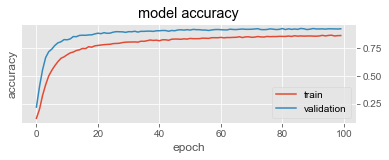

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
ax = plt.gca()
ax.set_xticklabels([])
plt.subplot(212)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [24]:
predicts = model.predict(x_test_r)
predout = np.argmax(predicts, axis=1)
testout = np.argmax(y_test_r, axis=1)
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=featuresdf.class_label.unique(),digits=4))

Best accuracy (on testing dataset): 92.73%
              precision    recall  f1-score   support

          go     0.9314    0.8559    0.8920       111
        stop     0.8783    0.8559    0.8670       118
         yes     0.9848    0.9559    0.9701       136
          no     0.8783    0.8860    0.8821       114
          up     0.9242    0.9457    0.9349       129
        down     0.8815    0.9520    0.9154       125
        left     0.9379    0.9784    0.9577       139
       right     0.9771    0.9343    0.9552       137
          on     0.8841    0.9313    0.9071       131
         off     0.9851    0.9496    0.9670       139

   micro avg     0.9273    0.9273    0.9273      1279
   macro avg     0.9263    0.9245    0.9249      1279
weighted avg     0.9284    0.9273    0.9273      1279



Text(0.5, 25.0, 'Predicted Label')

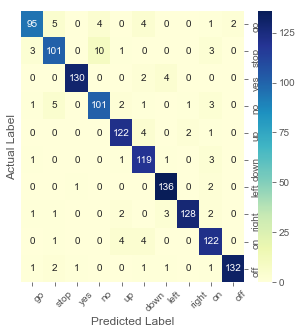

In [25]:
import seaborn as sn
df_cm = pd.DataFrame(confusion, index = featuresdf.class_label.unique(),
                  columns = featuresdf.class_label.unique())
plt.figure(figsize=(5,5))
ax=sn.heatmap(df_cm, cmap="YlGnBu", fmt="d", annot=True)
ax.set_xticklabels(
   ax.get_xticklabels(),
   rotation=45,
   horizontalalignment='left'
)
ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")

In [45]:
from tensorflow.keras.models import load_model
filename = 'weights.best.speechDL.hdf5'
model_test = load_model(filename)

In [46]:
features_01 = []
test_file_name = "voice01.wav"
(smp_01, smpR_01) = librosa.load(test_file_name, sr =sr)
print(smp_01)
mfccs = librosa.feature.mfcc(y=smp_01, sr=sr, n_mfcc=60)
pad_width = 32 - mfccs.shape[1]
mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
features_01.append([mfccs])
featuresdf_01 = pd.DataFrame(features_01, columns=['feature'])
data_01=np.array(featuresdf_01['feature'].tolist())
data_01.shape

[-6.1035156e-05 -3.0517578e-05  9.1552734e-05 ... -2.1667480e-03
 -1.1596680e-03 -2.1362305e-04]


(1, 60, 32)

In [47]:
test_01 = data_01.reshape(data_01.shape[0], num_rows, num_columns, num_channels)
print(test_01.shape)
predict_01 = model_test.predict(test_01)
predout_01 = np.argmax(predict_01, axis=1)
print(predout_01)
print("The voice01.wav is: ",le.classes_[predout_01])

(1, 60, 32, 1)
[6]
The voice01.wav is:  ['right']
